# Практическое задание

## Урок 6. Сегментация

датасет "CamVid (Cambridge-Driving Labeled Video Database)" (https://www.kaggle.com/carlolepelaars/camvid)

## Импорт библиотек и модулей 

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import cv2

from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import keras
import keras.backend as K

from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)

from tensorflow.keras.utils import plot_model

from IPython.display import clear_output

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Загрузка картинок

In [2]:
path_imgs = 'CamVid/train/'
path_masks = 'CamVid/train_labels/'

imgs_paths = list(Path(path_imgs).iterdir())
masks_paths = list(Path(path_masks).iterdir())

In [3]:
images = []
masks = []
image_size = (128, 192)


for i_img, i_mask in zip(imgs_paths, masks_paths):
    images.append(image.load_img(i_img, target_size=image_size))
    masks.append(image.load_img(i_mask, target_size=image_size))

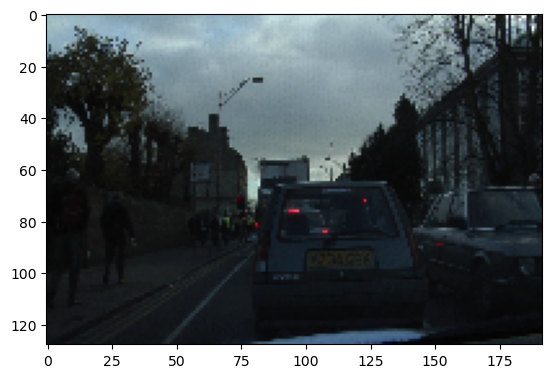

In [4]:
plt.imshow(images[1].convert('RGBA'))
plt.show()

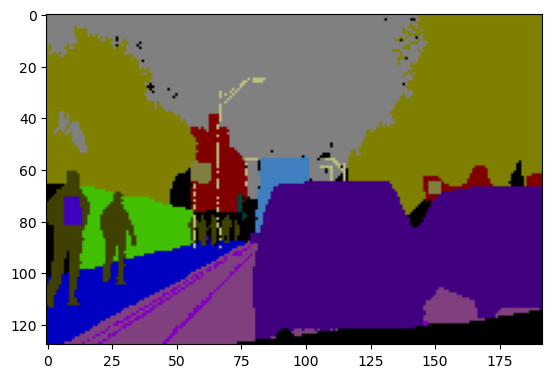

In [5]:
plt.imshow(masks[1].convert('RGBA'))
plt.show()

## Создание обучающей подвыборки

In [6]:
X = []

for img in images:
    x = image.img_to_array(img)
    X.append(x)

X = np.array(X)

In [7]:
print(X.shape)

(369, 128, 192, 3)


In [8]:
class_dict = pd.read_csv('CamVid/class_dict.csv')

In [9]:
def Color2index(y):
    arr_col = []
    for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
        arr_col.append([r, g, b]) 

    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind#, i-1

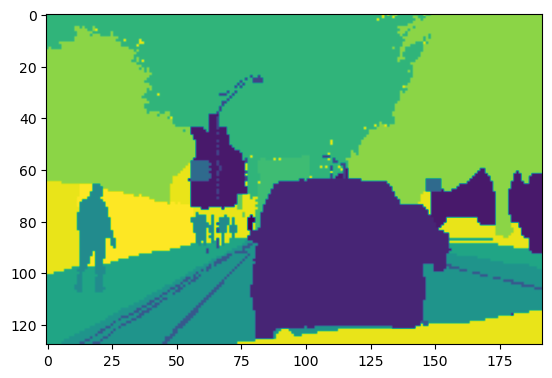

In [10]:
cat_yi, ind_yi = Color2index(image.img_to_array(masks[0]))
plt.imshow(ind_yi)
plt.show()  

In [11]:
ind_yi

array([[22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       ...,
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.]])

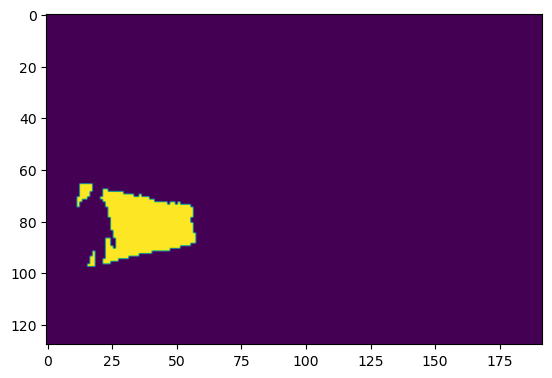

In [12]:
plt.imshow(cat_yi[..., 31])
plt.show()

In [13]:
cat_yi.shape

(128, 192, 32)

In [14]:
y = []

for mask in masks:
    y_cat, _ = Color2index(image.img_to_array(mask))
    y.append(y_cat)

y = np.array(y)

In [15]:
print(y.shape)

(369, 128, 192, 32)


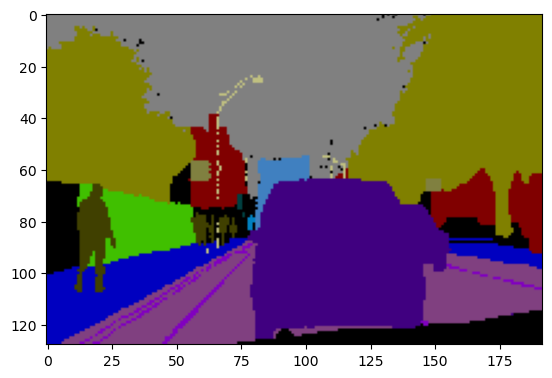

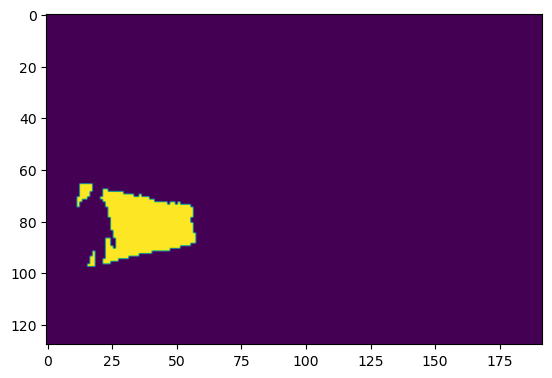

In [16]:
n = 0
plt.imshow(masks[n].convert('RGBA'))
plt.show()
img = y[n][..., 31]

plt.imshow(img)
plt.show()

## Разделение на тренировочную и тестовую подвыборки

In [17]:
N = 13
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

In [18]:
y_test.shape

(356, 128, 192, 32)

In [19]:
print(X_train.shape)
print(y_train.shape)

(13, 128, 192, 3)
(13, 128, 192, 32)


In [20]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

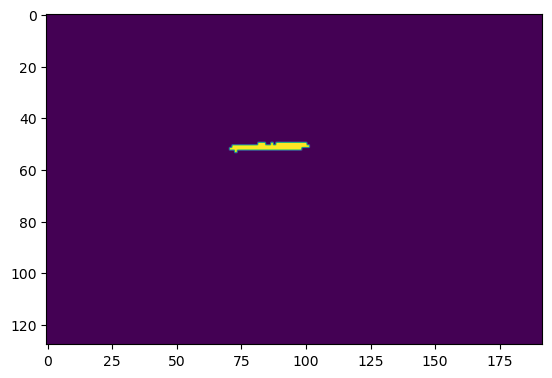

In [21]:
mask = y[31, ..., 31]
plt.imshow(mask);

Dice Coefficient of two same masks are 1.0


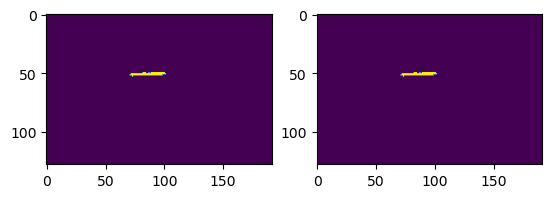

In [22]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(mask)
ax[1].imshow(mask)
print(f"Dice Coefficient of two same masks are {dice_coef(mask, mask)}")

## Создание и обучение U-net

In [23]:
def Unet(num_classes=14, input_shape=(128, 162, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [24]:
model_1 = Unet(32, (128, 192, 3))

# plot_model(model_1, to_file='model_1.png', show_shapes=True)

## Компиляция модели

In [25]:
model_1.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 192, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 192, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 192, 64)         256       ['block1_conv1[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 192, 64)         0         ['batch_normalization[0][0

                                                                    ]                             
                                                                                                  
 block4_conv3 (Conv2D)       (None, 16, 24, 512)          2359808   ['activation_8[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 16, 24, 512)          2048      ['block4_conv3[0][0]']        
 chNormalization)                                                                                 
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 32, 48, 256)          524544    ['batch_normalization_9[0][0]'
 anspose)                                                           ]                             
                                                                                                  
 batch_nor

 conv2d_5 (Conv2D)           (None, 128, 192, 64)         36928     ['activation_17[0][0]']       
                                                                                                  
 batch_normalization_18 (Ba  (None, 128, 192, 64)         256       ['conv2d_5[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 128, 192, 64)         0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 128, 192, 32)         18464     ['activation_18[0][0]']       
                                                                                                  
Total para

## Custom Callback

In [26]:
sample_image = X_test[0]
sample_mask = y_test[0]

In [27]:
def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

1/1 [==============================] - 1s 687ms/step
(1, 128, 192)


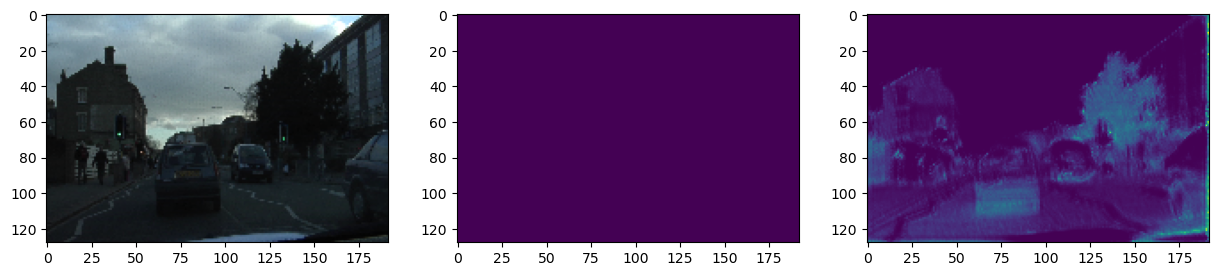

In [28]:
show_predictions(model_1)

1/1 [==============================] - 0s 199ms/step
(1, 128, 192)


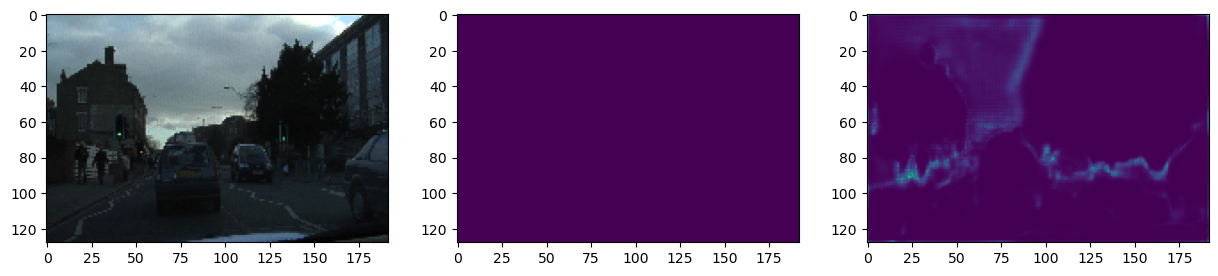


Sample Prediction after epoch 10
13/13 [==============================] - 84s 7s/step - loss: 0.2038 - dice_coef: 0.8902 - val_loss: 24.1841 - val_dice_coef: 0.1718
CPU times: total: 1h 27min 24s
Wall time: 14min 4s


In [36]:
%%time

history = model_1.fit(X_train, y_train,
                      epochs=10,
                      batch_size=1,
                      validation_data=(X_test, y_test),
                      callbacks=[DisplayCallback(patience=5)])

In [37]:
pred = model_1.predict(X_test)
print(pred.shape)

12/12 [==============================] - 61s 5s/step
(356, 128, 192, 32)


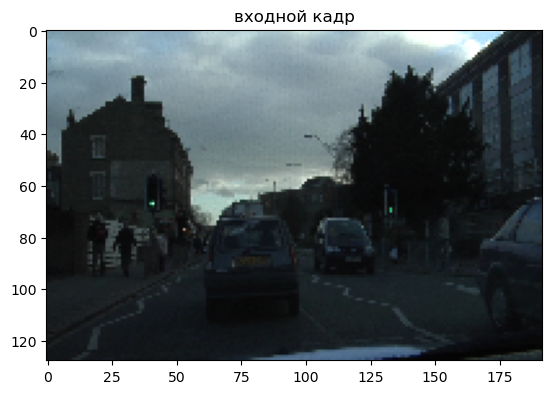

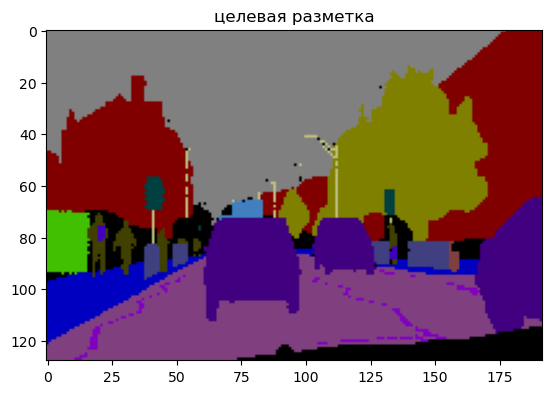

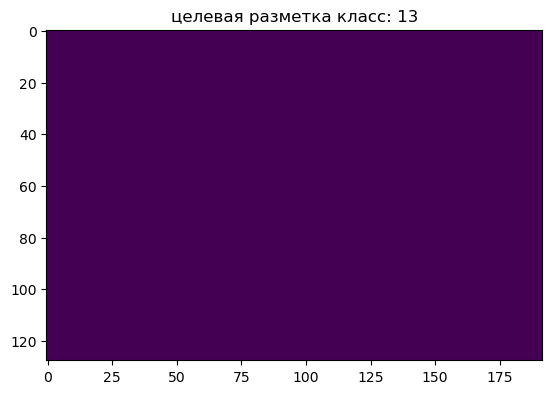

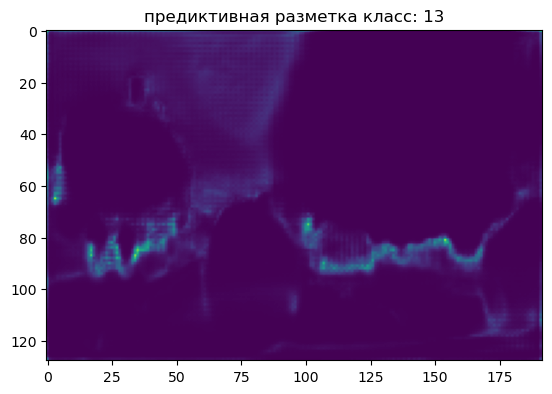

In [38]:
n = 0
class_ = 13
plt.imshow(images[N + n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(masks[N + n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_test[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()